In [ ]:
import pandas as pd 
from datetime import datetime
import numpy as np 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [ ]:
SPY_data = pd.read_csv("SPY_regression.csv")
 
# Change the Date column from object to datetime object 
SPY_data["Date"] = pd.to_datetime(SPY_data["Date"])
 
# Preview the data
SPY_data.head(10)


,Srno,Date,Open,High,Low,Close,Volume,Adj Close
0,0,2015-07-12,2090.419922,2090.419922,2066.780029,2077.070068,4043820000,2077.070068
1,1,2015-04-12,2051.239990,2093.840088,2051.239990,2091.689941,4214910000,2091.689941
2,2,2015-03-12,2080.709961,2085.000000,2042.349976,2049.620117,4306490000,2049.620117
3,3,2015-02-12,2101.709961,2104.270020,2077.110107,2079.510010,3950640000,2079.510010
4,4,2015-01-12,2082.929932,2103.370117,2082.929932,2102.629883,3712120000,2102.629883
5,5,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4245030000,2080.409912
6,6,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1466840000,2090.110107
7,7,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2852940000,2088.870117
8,8,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3884930000,2089.139893
9,9,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3587980000,2086.590088


In [ ]:
SPY_data.set_index('Date',inplace=True)
# Reverse the order of the dataframe in order to have oldest values at top
SPY_data.sort_values('Date',ascending=True)


,Srno,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,
2010-01-02,1473,1073.890015,1089.380005,1073.890015,1089.189941,4077610000,1089.189941
2010-01-03,1454,1105.359985,1116.109985,1105.359985,1115.709961,3847640000,1115.709961
2010-01-04,1431,1171.229980,1181.430054,1170.689941,1178.099976,4006870000,1178.099976
2010-01-06,1390,1087.300049,1094.770020,1069.890015,1070.709961,5271480000,1070.709961
2010-01-07,1368,1031.099976,1033.579956,1010.909973,1027.369995,6435770000,1027.369995
...,...,...,...,...,...,...,...
2015-12-05,145,2102.870117,2105.060059,2085.570068,2099.120117,3139520000,2099.120117
2015-12-06,123,2107.429932,2107.429932,2091.330078,2094.110107,2719400000,2094.110107
2015-12-08,81,2081.100098,2089.060059,2052.090088,2086.050049,4269130000,2086.050049


In [ ]:
SPY_data['High-Low_pct'] = (SPY_data['High'] - SPY_data['Low']).pct_change()
SPY_data['ewm_5'] = SPY_data["Close"].ewm(span=5).mean().shift(periods=1)
SPY_data['price_std_5'] = SPY_data["Close"].rolling(center=False,window= 30).std().shift(periods=1)
SPY_data['volume Change'] = SPY_data['Volume'].pct_change()
SPY_data['volume_avg_5'] = SPY_data["Volume"].rolling(center=False,window=5).mean().shift(periods=1)
SPY_data['volume Close'] = SPY_data["Volume"].rolling(center=False,window=5).std().shift(periods=1)


In [ ]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
 
def correlation(df,variables, n_rows, n_cols):
    fig = plt.figure(figsize=(8,6))
    #fig = plt.figure(figsize=(14,9))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = df.loc[:,var]
        ax.scatter(df["Adj Close"], asset, c = next(colors))
        ax.set_xlabel("Adj Close")
        ax.set_ylabel("{}".format(var))
        ax.set_title(var +" vs price")
    fig.tight_layout() 
    plt.show()


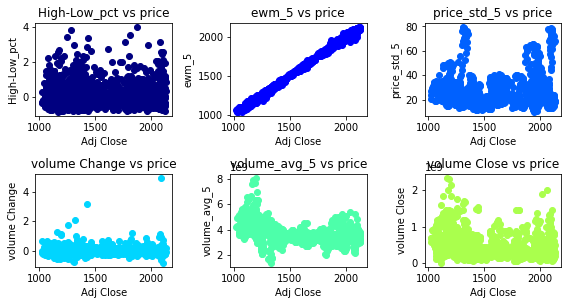

In [ ]:
variables = SPY_data.columns[-6:]  
correlation(SPY_data,variables,3,3)


In [ ]:
SPY_data.corr()['Adj Close'].loc[variables]

High-Low_pct    -0.010328
ewm_5            0.998513
price_std_5      0.100524
volume Change   -0.005446
volume_avg_5    -0.485734
volume Close    -0.241898
Name: Adj Close, dtype: float64

In [ ]:
SPY_data.isnull().sum().loc[variables]

High-Low_pct      1
ewm_5             1
price_std_5      30
volume Change     1
volume_avg_5      5
volume Close      5
dtype: int64

In [ ]:
# To train the model is necessary to drop any missing value in the dataset.

SPY_data = SPY_data.dropna(axis=0)

# Generate the train and test sets

train = SPY_data[SPY_data.index < datetime(year=2015, month=1, day=1).strftime("%d-%m-%Y")]

test = SPY_data[SPY_data.index >= datetime(year=2015, month=1, day=1).strftime("%d-%m-%Y")]
dates = test.index


In [ ]:
lr = LinearRegression()
X_test = test[["High-Low_pct","ewm_5","price_std_5","volume_avg_5","volume Change","volume Close"]]
Y_test = test["Adj Close"]
lr.fit(X_test,Y_test)



LinearRegression()

In [ ]:
close_predictions = lr.predict(X_test)   
mae = sum(abs(close_predictions - test["Adj Close"].values)) / test.shape[0]
print(mae)


18.415651465920472


In [ ]:
df = pd.DataFrame({'Date':dates,'Actual': Y_test, 'Predicted': close_predictions})
df1 = df.tail(25)
# set the date with string format for plotting
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
df1.set_index('Date',inplace=True)
error = df1['Actual'] - df1['Predicted']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


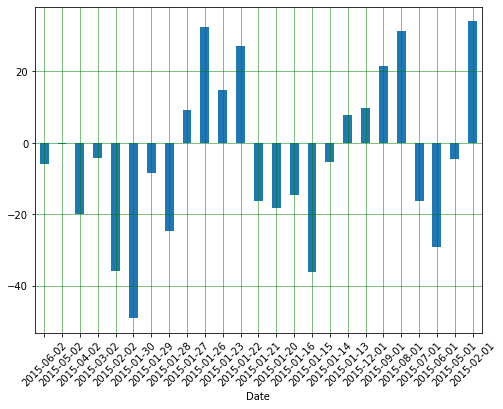

In [ ]:
error.plot(kind='bar',figsize=(8,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()
